# Assignment 2

**Quentin Le Roux**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import shapiro

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

## Part 1

$\mathbf{Exercise\, 1.}$ Illustrate with a meaningful example the bias variance decomposition, as we have seen it during lesson, for the non linear Support Vector Regression model, for increasing values of the regularization parameter _C_ (for example C = 1e-3, 1e-2, 1e-1, 1, 1e2, $\ldots$).

In [2]:
# Function declarations

f = lambda x: np.arctan(-3*x+5) + np.arctan(5*x-3)

def sample_data_batch(minimum, maximum, f, 
                      n_samples, noise_level=0.5):
    """
    Generates a data batch
    """
    X = np.linspace(minimum, maximum, n_samples)
    noise = noise_level * np.random.randn(n_samples)
    return [X, f(X) + noise]

def calculate(minimum, maximum, n_samples, noise_level, f,
              starting_parameter_value, parameter_range, sample_draws,
              show_plots=True):
    """
    Calculates and plots estimators for a SVR model given a set of
    data batch generator parameters
    """
    # Variable declarations
    all_bias = []
    all_variance = []
    all_bias_variance = []
    parameters = []
    parameter_value = starting_parameter_value
    if show_plots: plot_rows = int(parameter_range/2)+1
    
    # Matplotlib declaration
    if show_plots: 
        plt.figure(figsize=(12,15))
        plt.tight_layout()
    
    # Pseudo-gridsearch
    for parameter_magnitude in range(parameter_range):
        # Intermediary variable declaration
        predictions = []
        # Intermediary matplotlib declaration
        if show_plots: plt.subplot(plot_rows, 2, parameter_magnitude+1)
        for _ in range(sample_draws):
            # Data batch generation
            X, y = sample_data_batch(minimum, maximum, f, n_samples, noise_level)
            # Model training & prediction
            model = SVR(kernel='rbf', C = parameter_value)
            model.fit(X.reshape(-1,1), y)
            preds = model.predict(X.reshape(-1,1))
            predictions.append(preds)
            # Plotting of modeling
            if show_plots: 
                plt.title(f"\nparameter: {parameter_value}", x=0.22, y=0.82)
                plt.plot(X, preds, alpha=0.1)
        
        # Estimator Plotting
        X = np.linspace(minimum, maximum, n_samples)
        fx = f(X)
        expected_pred = np.mean(predictions, 0)
        if show_plots: 
            plt.scatter(X, y)
            plt.plot(X, expected_pred, color = "black", linewidth=1, linestyle=":")
        
        # Calculation of bias, variance, and mix
        bias = np.sum((fx - expected_pred)**2)
        var_pred = np.var(predictions, 0)
        variance = np.sum(var_pred)
        all_bias.append(bias)
        all_variance.append(variance)
        all_bias_variance.append(bias + variance)

        # Records parameter of pseudo-gridsearch
        parameters.append(f"{parameter_value}")
        # update parameter of pseudo-gridsearch
        parameter_value *= 10
        
    # Final plot display
    if show_plots: plt.show()
    
    return all_bias, all_variance, all_bias_variance, parameters

In [3]:
# Variable declarations

minimum = -3
maximum = 3
n_samples = 20
sample_draws = 20
noise_level = 1

starting_parameter_value = 1e-5
parameter_range = 10

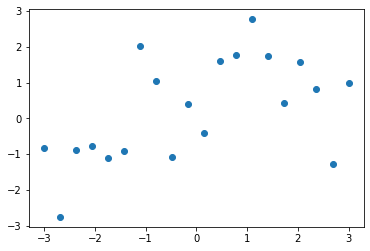

In [4]:
# Generation of example dataset

X, y = sample_data_batch(minimum, maximum, f, n_samples, noise_level)
plt.scatter(X,y)

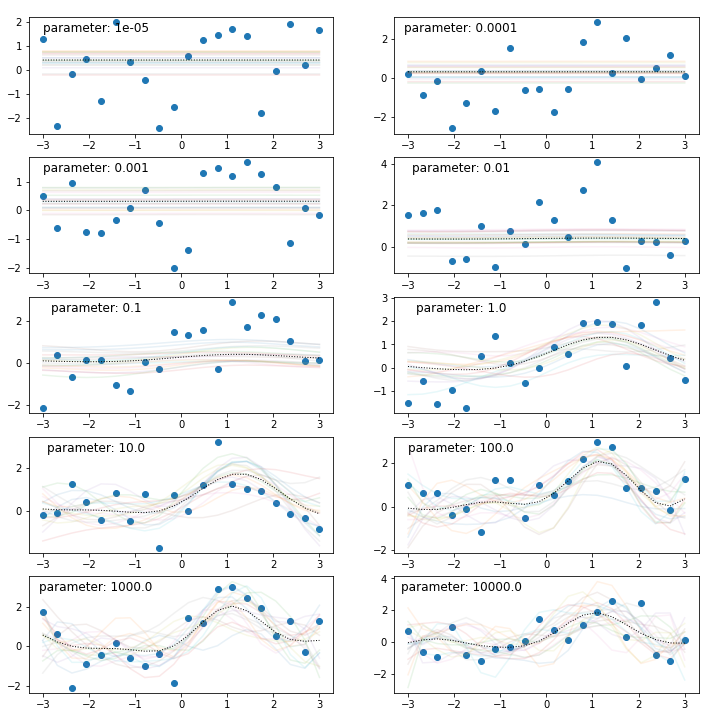

In [5]:
# Calculation 

all_bias, all_variance, all_bias_variance, parameters = calculate(
    minimum, maximum, 
    n_samples, noise_level, f,
    starting_parameter_value, 
    parameter_range, 
    sample_draws
)

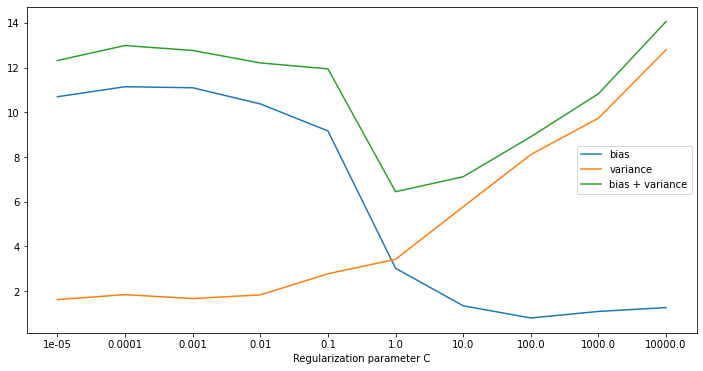

In [6]:
# Plotting of bias variance decomposition

plt.figure(figsize=(12,6))
plt.plot(parameters, all_bias, label = 'bias')
plt.plot(parameters, all_variance, label = 'variance')
plt.plot(parameters, all_bias_variance, label = 'bias + variance')
plt.xlabel('Regularization parameter C')
plt.legend()
plt.show()

We see that we achieve our best bias-variance trade-off with the given dataset parameters when the regularization parameter of the SVM model is set to 1.0.

<hr>

$\mathbf{Exercise\, 2.}$ Modify the example of Exercise 1 to show the effect of increasing noise values on the bias and on the variance.

In [7]:
# Variable declarations

noise_values = list(map(lambda x: float(x)/10, range(20)))
parameter_value = 1.
parameter_range = 1

In [8]:
# Calculates bias, variance, and mix for each noise level

biases = []
variances = []
bias_variances = []

for noise_level in noise_values:
    b, v, b_v, _ = calculate(
        minimum, maximum, 
        n_samples, noise_level, f,
        parameter_value, 
        parameter_range, 
        sample_draws,
        False
    )
    biases.append(b[0])
    variances.append(v[0])
    bias_variances.append(b_v[0])

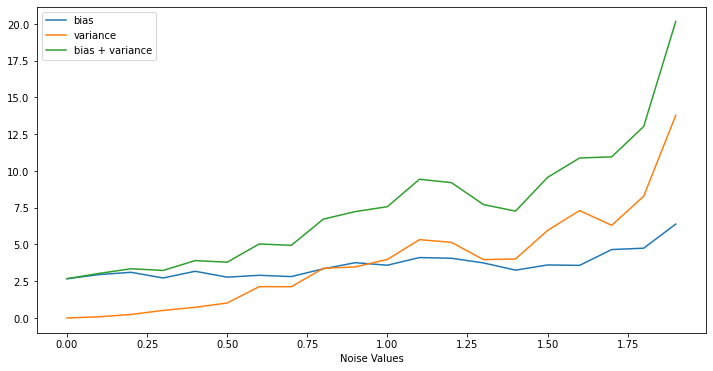

In [9]:
# Plotting of bias variance depended on noise

plt.figure(figsize=(12,6))
plt.plot(noise_values,biases, label = 'bias')
plt.plot(noise_values,variances, label = 'variance')
plt.plot(noise_values,bias_variances, label = 'bias + variance')
plt.xlabel('Noise Values')
plt.legend()
plt.show()

We see that the variance increases as the noise increases (from 0 to c. 9), while bias only slightly changes (from c. 2 to 3).

<hr>

$\mathbf{Exercise\, 3.}$ Still from the example of Exercise 1, compute the difference between training error and testing error for different values of the regularization parameter _C_. 

In [10]:
# Function declarations

def calculate_train_test_error(minimum, maximum, n_samples, noise_level, f,
                               starting_parameter_value, parameter_range, 
                               sample_draws):
    """
    Calculates and plots the train and test error for a SVR model given a set of
    data batch generator parameters
    """
    # Variable declarations
    train_error = []
    test_error = []
    parameters = []
    parameter_value = starting_parameter_value
    
    # Pseudo-gridsearch
    for parameter_magnitude in range(parameter_range):
        # Intermediary variable declaration
        train_e = []
        test_e = []
        # Intermediary matplotlib declaration
        for _ in range(sample_draws):
            # Data batch generation
            X_train, y_train = sample_data_batch(minimum, maximum, f, 
                                                 n_samples, noise_level)
            X_test, y_test = sample_data_batch(minimum, maximum, f, 
                                               n_samples, noise_level)
            # Model training & prediction
            model = SVR(kernel='rbf', C = parameter_value)
            model.fit(X_train.reshape(-1,1), y_train)
            train_preds = model.predict(X_train.reshape(-1,1))
            test_preds = model.predict(X_test.reshape(-1,1))
            # Records error
            train_e.append(np.mean((y_train - train_preds)**2))
            test_e.append(np.mean((y_test - test_preds)**2))

        # Records the error for the parameter
        train_error.append(np.mean(train_e))
        test_error.append(np.mean(test_e))
        # Records parameter of pseudo-gridsearch
        parameters.append(f"{parameter_value}")
        # update parameter of pseudo-gridsearch
        parameter_value *= 10
    
    return train_error, test_error, parameters

In [11]:
# Variable declarations

minimum = -3
maximum = 3
n_samples = 20
sample_draws = 20
noise_level = 1

starting_parameter_value = 1e-5
parameter_range = 10

In [12]:
# Calculation 

train_error, test_error, parameters = calculate_train_test_error(
    minimum, maximum, 
    n_samples, noise_level, f,
    starting_parameter_value, 
    parameter_range, 
    sample_draws
)

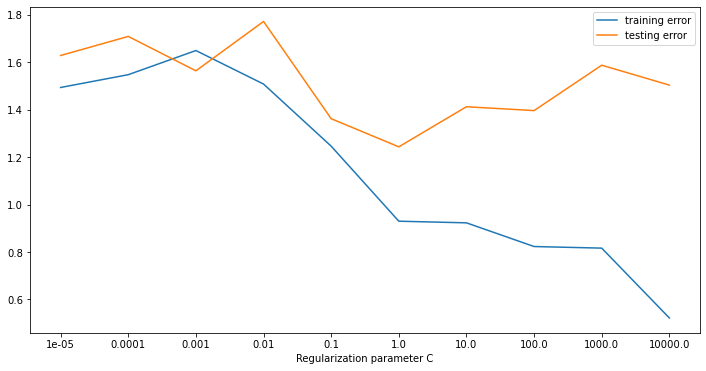

In [13]:
# Plotting of train-test errors

plt.figure(figsize=(12,6))
plt.plot(parameters, train_error, label = 'training error')
plt.plot(parameters, test_error, label = 'testing error')
plt.xlabel('Regularization parameter C')
plt.legend()
plt.show()

We see that the the training error decreases as the regularization parameter increases, while testing error plateaus after reaching parameter C equal to 1.0.

<hr>

## Part 2

We go back to the usual iris dataset:

In [14]:
iris_dataset = load_iris()

# extracting the relevant information
data = iris_dataset.data
data_feature_names = iris_dataset.feature_names
target = iris_dataset.target
target_names = iris_dataset.target_names

$\mathbf{Exercise\, 1.}$ Using bootstrap, compute a 95% confidence interval for the median of the feature $\mbox{sepal length (cm)}$

In [15]:
# Variable declaration

alpha = .05
bootstrap_repetitions = 10
threshold = alpha/2 * bootstrap_repetitions

iris_df = pd.DataFrame(data, columns=data_feature_names)

In [16]:
# Function declaration

def generate_bootstrap(data, repetitions):
    """
    Generates bootstrapped sets from a dataset, given a number of repetitions
    """
    boot = np.random.choice(data, 
                            size=[len(data), repetitions],
                            replace = True)
    return boot

def confidence_interval(bootstrapped_estimator, repetitions, threshold,
                        estimator_name="estimator"):
    """
    Calculates a confidence interval for a given bootstrapped estimator
    """
    # Calculating lower and upper quantiles
    low = np.sort(bootstrapped_estimator)[int(threshold)]
    up = np.sort(bootstrapped_estimator)[int(repetitions-threshold)]
    print(f"The {100-alpha}% confidence interval for the {estimator_name} is:",
          f"[{round(low,4)}, {round(up,4)}]")
    return low, up

In [17]:
# Bootstrapping dataset

boostrapped_data = generate_bootstrap(iris_df["sepal length (cm)"], 
                                      bootstrap_repetitions)

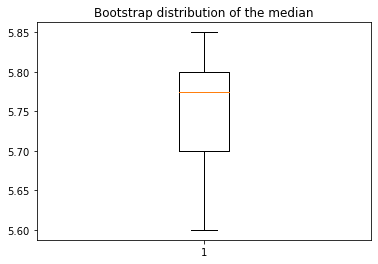

In [18]:
# Calculating median

boot_median = np.median(boostrapped_data, 0)

plt.figure()
plt.boxplot([boot_median])
plt.title('Bootstrap distribution of the median')
plt.show()

In [19]:
# Computation of a 95% confidence interval for the bootstrapped median

low, up = confidence_interval(boot_median, bootstrap_repetitions, threshold,
                              "median")

The 99.95% confidence interval for the median is: [5.6, 5.85]


<hr>

$\mathbf{Exercise\, 2.}$ Compute the null distribution for the hypothesis $H_0$: the mean of $\mbox{'sepal width (cm)'}$ is the same for $\mbox{setosa}$ and $\mbox{virginica}$. 

In [20]:
# setosa = index 0, virginica = index 2 in 'target' array
target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [21]:
# Variable declarations

bootstrap_repetitions = 1000

iris_df["target"] = target
setosa=iris_df[iris_df["target"] == 0]["sepal width (cm)"]
virginica=iris_df[iris_df["target"]== 2]["sepal width (cm)"]

In [22]:
# Function declarations

def compute_t(x, y):
    """
    Computes the statistics t for hypothesis testing
    """
    # Variable declaration
    n_x = len(x)
    n_y = len(y)
    # Mean and Variance calculation
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    sigma2_x = np.var(x)
    sigma2_y = np.var(y)
    return((mean_x-mean_y)/np.sqrt(sigma2_x/n_x+sigma2_y/n_y))

def compute_centered_data(x, y):
    """
    Computes the centered data of two distributions x and y
    """
    # Computation of statistic t
    t_obs = compute_t(x,y)
    # Computation for centering the distributions
    z = np.concatenate([x, y])
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # Translating the data around avg(z)
    x_tilde = x - mean_x + np.mean(z)
    y_tilde = y - mean_y + np.mean(z)
    return x_tilde, y_tilde
    
def bootstrapped_t_calculate(x, y, repetitions):
    """
    Computed the bootstrapped t statistics for two distributions x and y
    """
    # Variable declaration
    n_x = len(x)
    n_y = len(y)
    t_bootstrapped = []
    # Computation of centered data
    x_tilde, y_tilde = compute_centered_data(x, y)
    # Centered data concatenation
    z_tilde = np.concatenate([x_tilde, y_tilde])
    # Generation of B bootstrapped samples
    bootstrapped_samples = np.random.choice(z_tilde, 
                                            (repetitions, n_x + n_y), 
                                            replace=True)
    # computation of the t statistic for each bootstrapped sample
    for i in range(repetitions):
        x_simulated = bootstrapped_samples[i, :n_x]
        y_simulated = bootstrapped_samples[i, n_x:]
        t_bootstrapped.append(compute_t(x_simulated, y_simulated))
    return t_bootstrapped

def print_null_distribution(t_obs, t_boot):
    """
    Plots the null hypothesis distribution
    """
    plt.figure(figsize=(12,6))
    plt.hist(t_boot, 25, histtype='step')
    plt.title('Null distribution')
    plt.axvline(x=t_obs)
    plt.show()

In [23]:
# Computates observed t statistic and bootstrapped t statistic

t_observed = compute_t(setosa, virginica)
t_bootstrapped = bootstrapped_t_calculate(setosa, virginica, 
                                          bootstrap_repetitions)

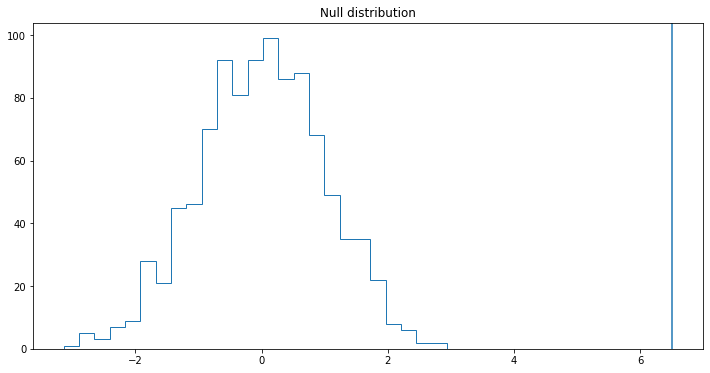

In [24]:
print_null_distribution(t_observed, t_bootstrapped)

$\mathbf{Exercise\, 3.}$ Compute a 2-sided bootstrapped p-value for the difference between the means of $\mbox{setosa}$ and $\mbox{virginica}$.

In [25]:
# Function declarations

def hypothesis_testing(t_obs, t_boot, repetitions):
    """
    Computes the hypothesis testing between an observed statistic t
    and its bootstrapped counterpart
    """
    # Computes the significance of our test
    boot_stat = np.sum(np.abs(t_obs)>np.abs(t_boot))/repetitions
    confidence_interval = np.quantile(t_boot, [0.025, 0.975])
    # Prints results
    print(f"The 2-sided bootstrapped p-value (significance of the test) is: {1-boot_stat}")
    print(f"The 95% coinfidence interval for the null hypothesis: {confidence_interval}")
    print(f"Observed statistic: {t_obs}")
    if t_obs >= confidence_interval[0] and t_obs <= confidence_interval[1]:
        print("\nWe cannot reject the null hypothesis.")
        print("The 'sepal width (cm)' mean is the same for setosa and virginica.")
    else:
        print("\nWe can reject the null hypothesis.")
        print("The 'sepal width (cm)' mean is the different between setosa and virginica.")

In [26]:
# Computes hypothesis testing

hypothesis_testing(t_observed, t_bootstrapped, bootstrap_repetitions)

The 2-sided bootstrapped p-value (significance of the test) is: 0.0
The 95% coinfidence interval for the null hypothesis: [-1.91592547  1.87372407]
Observed statistic: 6.515836546140536

We can reject the null hypothesis.
The 'sepal width (cm)' mean is the different between setosa and virginica.


$\mathbf{Exercise\, 4.}$ The central limit theorem (Lindeberg-Levy version) states that given a sequence $X_1, X_2, \ldots, X_n $ of independent variables drawn from the same ditribution, $X_i\sim F$, then:

$$ \sqrt{n} \left( \frac{1}{n} \sum X_i - \mu \right) \rightarrow \mathcal{N}(0,\sigma^2),$$

where $\mu = \mathbf{E}[F]$ and $\sigma^2 = Var(F)$.
In particular, the sample mean converges to the normal distribution:

$$ \frac{1}{n} \sum X_i \rightarrow \mathcal{N}(\mu,\frac{\sigma^2}{n}). $$

Let $F = Exponential(2)$ be the exponential distribution with parameter $\lambda = 2$, and let $X_1, X_2, \ldots, X_{20}$ be 20 samples from this distribution. Verify for this case the central limit theorem via bootstrapping. 

__**__ Remember, the mean of the exponential distribution is $\mathbf{E}(F) = 1/\lambda$, while the variance is $Var(F) = 1/\lambda^2$ __**__

Hint:

- Draw n samples (n large) from the Exponential distribution (be careful, when using $\mbox{np.random.exponential}$ the required input scale parameter is $\frac{1}{\lambda}$).
- Compute their average $\frac{\sum X_i}{20}$ and store the result

In [27]:
# Variable declarations

lambda_value = 2
n_samples = 20
n_large = 10000
E_f = 1/lambda_value
V_f = (1/lambda_value)**2

In [28]:
# Function declarations

mean = lambda data: np.mean(data)

def generate_bootstrap_2(data, repetitions):
    """
    Generates bootstrapped sets from a dataset, given a number of repetitions
    """
    # we rereverse the size parameters compared to generate_bootstrap()
    boot = np.random.choice(data, 
                            size=[repetitions, len(data)],
                            replace = True)
    return boot

def generate_normal_distribution(mean, variance, n):
    """
    Generates a dataset from the normal distribution given a mean and variance
    """
    return np.random.normal(mean, variance, n)

def calculate_bootstrapped_means(lambda_value, n_samples, repetitions):
    """
    Calculates the bootstrapped means for a given dataset
    """
    # Generates a dataset from the exponential distribution
    exponential_samples = np.random.exponential(1/lambda_value, n_samples)
    # Generates bootstrapped samples and bootstrapped means
    boot_samples = generate_bootstrap_2(exponential_samples, n_large)
    boot_means = list(map(mean, boot_samples))
    return boot_means

In [29]:
# Computes n large (here 100,000) bootstrapped means from data sampled from 
# 20 samples from the Exponential distribution

bootstrapped_means = calculate_bootstrapped_means(
    lambda_value,
    n_samples,
    n_large)

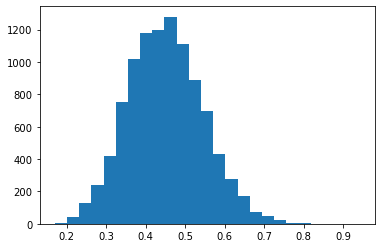

In [30]:
# Plotting our bootstrapped means

plt.figure()
plt.hist(bootstrapped_means, bins=25)
plt.show()

In [31]:
shapiro(bootstrapped_means)

ShapiroResult(statistic=0.9965776205062866, pvalue=1.587006859206288e-14)